# File Import and Environment Setup

In [ ]:
from google.colab import files
uploaded = files.upload()
! unzip Fake.csv.zip
! unzip True.csv.zip

Saving True.csv.zip to True.csv.zip
Saving Fake.csv.zip to Fake.csv.zip
Archive:  Fake.csv.zip
  inflating: Fake.csv                
Archive:  True.csv.zip
  inflating: True.csv                


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

from sklearn.model_selection import train_test_split

# Preprocessing and Visualization

In [ ]:
fake_df=pd.read_csv('Fake.csv')
fake_df['label'] = pd.Series(['fake']*len(fake_df))
true_df = pd.read_csv('True.csv')
true_df['label'] = pd.Series(['real']*len(true_df))

In [ ]:
fake_df.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",fake
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",fake
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",fake
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",fake
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",fake


In [ ]:
true_df['text'][3]

'WASHINGTON (Reuters) - Trump campaign adviser George Papadopoulos told an Australian diplomat in May 2016 that Russia had political dirt on Democratic presidential candidate Hillary Clinton, the New York Times reported on Saturday. The conversation between Papadopoulos and the diplomat, Alexander Downer, in London was a driving factor behind the FBI’s decision to open a counter-intelligence investigation of Moscow’s contacts with the Trump campaign, the Times reported. Two months after the meeting, Australian officials passed the information that came from Papadopoulos to their American counterparts when leaked Democratic emails began appearing online, according to the newspaper, which cited four current and former U.S. and foreign officials. Besides the information from the Australians, the probe by the Federal Bureau of Investigation was also propelled by intelligence from other friendly governments, including the British and Dutch, the Times said. Papadopoulos, a Chicago-based inte

In [ ]:
fake_df['subject'].value_counts()

News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: subject, dtype: int64

## Cleaning text field


1.   Remove "Reuters" tag from true news text, since all true news were extracted from Reuters
2.   



In [ ]:
import re
def clean_txt(txt):
  # remove reuters
  txt = re.sub('^[A-Z]*\/?[A-Z]*( ){0,1}\(Reuters\)( - )?|\(Reuters\)', '', txt)

  #remove source url at then end
  txt = re.sub('( -- )?Source link: .+$', '', txt)
  
  return txt

In [ ]:
true_df['text'] = true_df['text'].apply(lambda x: clean_txt(x))

In [ ]:
true_df.head(10)

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",real
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",real
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",real
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",real
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",real
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON - The White ...",politicsNews,"December 29, 2017",real
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla - President Donald Trump...",politicsNews,"December 29, 2017",real
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017",real
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017",real
9,Alabama official to certify Senator-elect Jone...,Alabama Secretary of State John Merrill said h...,politicsNews,"December 28, 2017",real


## Combining false and real news dataset and split train and test set

In [ ]:
combined_df = fake_df.append(true_df, ignore_index = True)
X_train, X_test, y_train, y_test = train_test_split(combined_df.drop(columns='label'), combined_df['label'], test_size = 0.2)

## I. Date Patterns

In [ ]:
# parse date
def validate(date):
  for fmt in ('%B %d, %Y', '%d-%b-%y'):
    try:
      return datetime.strptime(date, fmt)
    except ValueError:
      return None
fake_df['date'] = fake_df['date'].apply(lambda x: validate(x))

## II. Term frequency in Title

Potential hyperparameter tuning:

1.   Number of word tokens to include in text vectorizer
2.   



In [ ]:
stopwords = set(STOPWORDS)
fake_titles = ' '.join(t for t in fake_df.title)
fake_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(fake_titles)

Keywords in fake new title


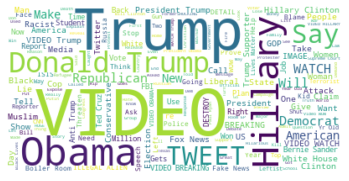

In [ ]:
print("Keywords in fake new title")
plt.imshow(fake_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [ ]:
true_titles = ' '.join(t for t in true_df.title)
true_wordcloud = WordCloud(stopwords=stopwords, background_color="white").generate(true_titles)

Keywords in true new title


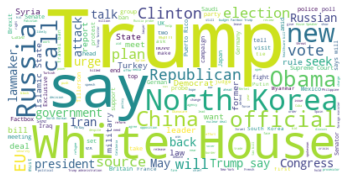

In [ ]:
print("Keywords in true new title")
plt.imshow(true_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### TF-IDF vectorization and PCA

In [ ]:
# TODO: remove number tokens 
vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1,2), token_pattern=r'[a-zA-Z]+', max_features=5000)
title_vec = vectorizer.fit_transform(X_train['title'])

In [ ]:
from sklearn.decomposition import PCA
from scipy.sparse import csr_matrix
title_vec_dense = title_vec.todense()
title_pca = PCA()
title_pca.fit(title_vec_dense)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [ ]:
cum_exp_ratio = np.cumsum(title_pca.explained_variance_ratio_) 

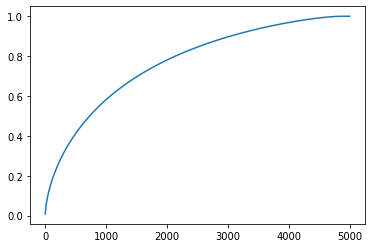

In [ ]:
plt.plot(cum_exp_ratio)

## III. Context Sensitive Feature Extraction 